<a href="https://colab.research.google.com/github/askchris/hello-world/blob/main/hellp-world.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ✨Introduction
I took a career break in Jan 2024 and have just crossed the 7-month mark. After learning the fundamentals in data science, I want to analyse my personal finances to understand how my career break has impacted how I spend money using my own personal finance dataset dated form Jan 2023 to Jul 2024.

🎯**Objective:**\
To have a better understanding of how my expenses have changed after taking a career break and derive ideas about how my lifestyle expenses would look like after I retire.

📌**Questions:**
1. Pre-Break vs. Post-Break Spending Analysis:
  - How has your overall spending changed since taking your career break in 2024 compared to 2023?
  - Which expense categories (e.g., groceries, entertainment, travel) have seen the most significant change in spending?
2. Monthly Spending Trends:
  - What are the monthly spending trends for each category from 2023 to date?
  - Are there any seasonal patterns in your spending (e.g., higher spending during holidays)?
3. Impact of Career Break on Essential vs. Non-Essential Spending:
  - How did your career break impact spending on essential items (e.g., rent, utilities) versus non-essential items (e.g., dining out, entertainment)?
4. Expense Reduction Strategies:
  - What expense categories have been successfully reduced since the start of your career break?
  - Are there further opportunities to optimize and reduce unnecessary spending?


##Initial Notebook Setup

In [138]:
# clone github repository
!git clone https://github.com/askchris/hello-world.git

fatal: destination path 'hello-world' already exists and is not an empty directory.


In [139]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# helpful modules
!pip install fuzzywuzzy
import fuzzywuzzy
from fuzzywuzzy import process

##Load, Check and Clean Dataset
Load the CSV file that contains the transactional data that I have compiled from banking records and an expense tracker app that I use to record cash expenses.

In [140]:
# load CSV file containing personal finance data from Jan 2023 to Jul 2024
finance_filepath = "/content/hello-world/datasets/Personal Finance - Raw Data.csv"
finance_data = pd.read_csv(finance_filepath)

# duplicate finance_data so that we do not overwrite the original dataset.
cleaned_finance_data = finance_data

# view first 5 records of the dataset
finance_data.head()

,Application Date,Wallet,Type,Category name,Amount,Currency,Note,Labels,Author
0,2023-01-01,NaN,NaN,Bills & Subscriptions,11.73,NaN,Property Tax,NaN,NaN
1,2023-01-01,NaN,NaN,Bills & Subscriptions,38.63,NaN,Utilities,NaN,NaN
2,2023-01-01,NaN,NaN,Entertainment,50,NaN,Entertainment,NaN,NaN
3,2023-01-01,NaN,NaN,Groceries,61.86,NaN,Groceries,NaN,NaN
4,2023-01-01,NaN,NaN,Gifts and Ocassions,72,NaN,Chinese New Year,NaN,NaN


In [141]:
print("There are " + str(len(finance_data)) + " records in the dataset")

There are 2148 records in the dataset


Examine the dataset to identify any data issues.

In [142]:
# get the number of missing data points per column
missing_values_count = finance_data.isnull().sum()

# look at the # of missing points in the 9 columns
missing_values_count[0:9]

,0
Application Date,0
Wallet,1554
Type,1554
Category name,0
Amount,0
Currency,1551
Note,2
Labels,2148
Author,1577


###Removing unusable columns and populating columns with some missing values
As there are more than 50% null values in some columns, we will not be using these records in our analysis:
- Wallet
- Type
- Currency
- Labels
- Author

In [143]:
# Drop columns (Wallet, Type, Currency, Labels and Author) from cleaned_finance_data
cleaned_finance_data = cleaned_finance_data.drop(columns=['Wallet', 'Type', 'Currency', 'Labels', 'Author'])

cleaned_finance_data.head()

,Application Date,Category name,Amount,Note
0,2023-01-01,Bills & Subscriptions,11.73,Property Tax
1,2023-01-01,Bills & Subscriptions,38.63,Utilities
2,2023-01-01,Entertainment,50,Entertainment
3,2023-01-01,Groceries,61.86,Groceries
4,2023-01-01,Gifts and Ocassions,72,Chinese New Year


Since the Note column only has 2 records with null values, we will replace the null values with "N/A".

In [144]:
# Replace null values in Note column with "N/A" in cleaned_finance_data
cleaned_finance_data[['Note']] = cleaned_finance_data[['Note']].fillna(value="N/A")

# Double check if there are any more missing data points per column
missing_values_count = cleaned_finance_data.isnull().sum()

# look at the # of missing points in the 4 columns
missing_values_count[0:4]

,0
Application Date,0
Category name,0
Amount,0
Note,0


###Checking the Application Date Column
As the dataset contains records from different data sources (banking records and expense tracker app), I want to be prudent and check if the date values in the Application Date column are consistent.

In [145]:
# print the first few rows
cleaned_finance_data['Application Date'].head()

,Application Date
0,2023-01-01
1,2023-01-01
2,2023-01-01
3,2023-01-01
4,2023-01-01


While the first 5 records are dates, the data type of this column is "object". This data type is used for storing various types of data types and this implies that not all the values in these column are recognised as dates.

Let's do a further investigation.

In [146]:
# check the length of the values in the Application Date column.
date_lengths = cleaned_finance_data['Application Date'].str.len()
date_lengths.value_counts()

,count
Application Date,
11,843
25,594
7,433
6,277
8,1


In [147]:
# examine first 5 records with 6 characters in Application Date column.
indices = np.where([date_lengths == 6])[1]
cleaned_finance_data.loc[indices]["Application Date"].head()

,Application Date
1090,1/1/24
1091,1/1/24
1094,2/1/24
1096,3/1/24
1097,3/1/24


In [148]:
# examine first 5 records with 7 characters in Application Date column.
indices = np.where([date_lengths == 7])[1]
cleaned_finance_data.loc[indices]["Application Date"].head()

,Application Date
1125,10/1/24
1126,10/1/24
1127,10/1/24
1130,11/1/24
1132,12/1/24


In [149]:
# examine first 5 records with 8 characters in Application Date column.
indices = np.where([date_lengths == 8])[1]
cleaned_finance_data.loc[indices].head()

,Application Date,Category name,Amount,Note
1088,31/12/23,Bills & Subscriptions,35.23,MYSINGTELAPP STBILL SINGAPORE SG


In [150]:
# examine first 5 records with 11 characters in Application Date column.
indices = np.where([date_lengths == 11])[1]
cleaned_finance_data.loc[indices]["Application Date"].head()

,Application Date
0,2023-01-01
1,2023-01-01
2,2023-01-01
3,2023-01-01
4,2023-01-01


In [151]:
# examine first 5 records with 2 5can characters in Application Date column.
indices = np.where([date_lengths == 25])[1]
cleaned_finance_data.loc[indices]["Application Date"].head()

,Application Date
170,2023-08-02T00:44:23+00:00
171,2023-08-02T23:44:54+00:00
172,2023-08-02T23:45:14+00:00
174,2023-08-02T04:17:32+00:00
175,2023-08-02T00:43:53+00:00


From the above, we can see that we have 3 different date formats.
1. DD/MM/YY
2. YYYY-MM-DD
3. YYYY-MM-DDTHH:MM:SS+00:00

Note: It's strange that YYYY-MM-DD is shown to have 11 characters. Therefore there must be a leading/trailing whitespace that needs to be stripped.

We will convert all the date formats to YYYY-MM-DD for consistency.

In [152]:
# strip whitespaces of values in Application Date column and store in Tmp Date
cleaned_finance_data['Tmp Date'] = cleaned_finance_data['Application Date'].str.strip()
date_lengths = cleaned_finance_data['Tmp Date'].str.len()

# Clean records with less than 10 characters in Tmp Date column.
indices = np.where([date_lengths < 10])[1]
cleaned_finance_data.loc[indices, 'Date Cleaned'] = pd.to_datetime(cleaned_finance_data.loc[indices, 'Tmp Date'], format="%d/%m/%y")

# Clean records with 10 characters in Tmp Date column.
indices = np.where([date_lengths == 10])[1]
cleaned_finance_data.loc[indices, 'Date Cleaned'] = pd.to_datetime(cleaned_finance_data.loc[indices, 'Tmp Date'], format="%Y-%m-%d")

# Clean records with 25 characters in Tmp Date column.
indices = np.where([date_lengths == 25])[1]
cleaned_finance_data.loc[indices, 'Date Cleaned'] = pd.to_datetime(cleaned_finance_data.loc[indices, 'Tmp Date'].str[:10])

# Convert all records to Datetime data type.
cleaned_finance_data['Date Cleaned'] = pd.to_datetime(cleaned_finance_data['Date Cleaned'])

# print the first few rows
cleaned_finance_data['Date Cleaned'].head()

,Date Cleaned
0,2023-01-01
1,2023-01-01
2,2023-01-01
3,2023-01-01
4,2023-01-01


###Checking the Amount Column
In the Amount column, we can also see that there are some records with 2 decimal places(float) and some records with whole numbers. When exploring further, we also found that some records have commas (e.g. 1,000).

We will convert all the values to float for consistency.

In [164]:
# convert the Amount column from string to float
cleaned_finance_data['Tmp Amount'] = cleaned_finance_data['Amount']
cleaned_finance_data['Tmp Amount'] = [float(str(i).replace(",", "")) for i in cleaned_finance_data['Tmp Amount']]
cleaned_finance_data['Amount Cleaned'] = cleaned_finance_data['Tmp Amount'].astype(float)

cleaned_finance_data['Amount Cleaned']

,Amount Cleaned
0,11.73
1,38.63
2,50.00
3,61.86
4,72.00
...,...
2143,2.18
2144,5.84
2145,12.00
2146,6.64


###Checking the Category name Column
In the Category name column, we let's see if there are any discrepancies or dirty data that needs to be cleaned.

In [154]:
# get all the unique values in the 'Category name' column
category_names = cleaned_finance_data['Category name'].unique()

# sort them alphabetically and then take a closer look
category_names.sort()
category_names

array(['Bank Interests', 'Bills & Subscriptions', 'Business Expenses',
       'CDAC Contribution', 'CPF Contribution', 'Credit Card Rebates',
       'Diversified Portfolio', 'Dividends', 'Entertainment',
       'Family Emergency Fund', 'Gifts and Ocassions', 'Groceries',
       'Hawker Food', 'Health Sinking Fund', 'Household Allowance',
       'Other Income', 'Personal Care', 'Personal Development',
       'Personal Insurance', 'Restaurant & Fast Food', 'SRS Contribution',
       'Salary', 'Shopping', 'Transfers', 'Transportation', 'Travel',
       'Travel & Vacation', 'Warchest'], dtype=object)

There are a few issues with the Category name column:
1. There are records with values 'Travel' and 'Travel & Vacation', which are essentially the same category. We will combine them under 'Travel'.
2. Remove unnecessary transactional rows such as 'Bank Interests', 'Credit Card Rebates', 'Transfers', 'Business Expenses' and 'CDAC Contribution' that are not meaningful for this analysis.
3. The values in the  Category name column show that the records contains savings, expense and income transactions. We can create a 'Type' column to categorise the records into 'Expense', 'Income' or 'Savings'.
4. We can also further categorise expenses into sub types–'Needs' or 'Wants'.

| Category name | Type | Sub_Type |
| - | - | - |
| Bills & Subscriptions | Expense | Needs |
| CPF Contribution | Savings |  |
| Diversified Portfolio | Savings |  |
| Dividends | Income |  |
| Entertainment | Expense | Wants |
| Family Emergency Fund | Savings |  |
| Gifts and Ocassions | Expense | Wants |
| Groceries | Expense | Needs |
| Hawker Food | Expense | Needs |
| Health Sinking Fund | Savings |  |
| Household Allowance | Expense | Needs |
| Other Income | Income |  |
| Personal Care | Expense | Needs |
| Personal Development | Expense | Wants |
| Personal Insurance | Expense | Needs |
| Restaurant & Fast Food | Expense | Wants |
| SRS Contribution | Savings |  |
| Salary | Income |  |
| Shopping | Expense | Wants |
| Transportation | Expense | Needs |
| Travel | Expense | Wants |
| Warchest | Savings |  |



Rename records with values 'Travel & Vacation' to 'Travel'.


In [155]:
# rename all 'Travel & Vacation' values to 'Travel'
cleaned_finance_data.loc[cleaned_finance_data['Category name'] == "Travel & Vacation", "Category name"] = "Travel"

Remove unnecessary transactional records such as 'Bank Interests', 'Credit Card Rebates', 'Transfers' and Business Expenses that are not meaningful for this analysis.

In [156]:
# remove rows where Category name is 'Bank Interests', 'Credit Card Rebates' or 'Transfers'
cleaned_finance_data.drop(cleaned_finance_data[cleaned_finance_data['Category name'] == "Bank Interests"].index, inplace = True)
cleaned_finance_data.drop(cleaned_finance_data[cleaned_finance_data['Category name'] == "Credit Card Rebates"].index, inplace = True)
cleaned_finance_data.drop(cleaned_finance_data[cleaned_finance_data['Category name'] == "Transfers"].index, inplace = True)
cleaned_finance_data.drop(cleaned_finance_data[cleaned_finance_data['Category name'] == "Business Expenses"].index, inplace = True)
cleaned_finance_data.drop(cleaned_finance_data[cleaned_finance_data['Category name'] == "CDAC Contribution"].index, inplace = True)

# get all the unique values in the 'Category name' column
category_names = cleaned_finance_data['Category name'].unique()

# sort them alphabetically and then take a closer look
category_names.sort()
category_names

array(['Bills & Subscriptions', 'CPF Contribution',
       'Diversified Portfolio', 'Dividends', 'Entertainment',
       'Family Emergency Fund', 'Gifts and Ocassions', 'Groceries',
       'Hawker Food', 'Health Sinking Fund', 'Household Allowance',
       'Other Income', 'Personal Care', 'Personal Development',
       'Personal Insurance', 'Restaurant & Fast Food', 'SRS Contribution',
       'Salary', 'Shopping', 'Transportation', 'Travel', 'Warchest'],
      dtype=object)

The values in the  Category name column show that the records contains savings, expense and income transactions. We can create a 'Type' column to categorise the records into 'Expense', 'Income' or 'Savings'.

In [157]:
category_column = cleaned_finance_data['Category name']

# list of conditions
conditions = [
  (category_column == "Bills & Subscriptions"),
  (category_column == "CPF Contribution"),
  (category_column == "Diversified Portfolio"),
  (category_column == "Dividends"),
  (category_column == "Entertainment"),
  (category_column == "Family Emergency Fund"),
  (category_column == "Gifts and Ocassions"),
  (category_column == "Groceries"),
  (category_column == "Hawker Food"),
  (category_column == "Health Sinking Fund"),
  (category_column == "Household Allowance"),
  (category_column == "Other Income	Income"),
  (category_column == "Personal Care"),
  (category_column == "Personal Development"),
  (category_column == "Personal Insurance"),
  (category_column == "Restaurant & Fast Food"),
  (category_column == "SRS Contribution"),
  (category_column == "Salary"),
  (category_column == "Shopping"),
  (category_column == "Transportation"),
  (category_column == "Travel"),
  (category_column == "Warchest")
]

# list of values to return
choices = [
  "Expense",
  "Savings",
  "Savings",
  "Income",
  "Expense",
  "Savings",
  "Expense",
  "Expense",
  "Expense",
  "Savings",
  "Expense",
  "Income",
  "Expense",
  "Expense",
  "Expense",
  "Expense",
  "Savings",
  "Income",
  "Expense",
  "Expense",
  "Expense",
  "Savings"
]

# create a new column in the cleaned_finance_data based on the conditions
cleaned_finance_data["Type"] = np.select(conditions, choices, "")

4. We can also further categorise expenses into sub types–'Needs' or 'Wants'.

In [158]:
category_column = cleaned_finance_data['Category name']

# List of conditions
conditions = [
  (category_column == "Bills & Subscriptions"),
  (category_column == "Entertainment"),
  (category_column == "Gifts and Ocassions"),
  (category_column == "Groceries"),
  (category_column == "Hawker Food"),
  (category_column == "Household Allowance"),
  (category_column == "Personal Care"),
  (category_column == "Personal Development"),
  (category_column == "Personal Insurance"),
  (category_column == "Restaurant & Fast Food"),
  (category_column == "Shopping"),
  (category_column == "Transportation"),
  (category_column == "Travel")
]
# List of values to return
choices = [
  "Needs",
  "Wants",
  "Wants",
  "Needs",
  "Needs",
  "Needs",
  "Needs",
  "Wants",
  "Needs",
  "Wants",
  "Wants",
  "Needs",
  "Wants"
]
# create a new column in the cleaned_finance_data based on the conditions
cleaned_finance_data["Sub_Type"] = np.select(conditions, choices, "")

###Removing Columns That Are No Longer Needed
Once all the data cleaning has been completed, both temporary and unnecessary columns are dropped as they are no longer needed.

In [159]:
# remove all tmp columns
cleaned_finance_data = cleaned_finance_data.drop(columns=['Tmp Date', 'Tmp Amount'])

# remove all Application Date and Amount columns as they are no longer needed
cleaned_finance_data = cleaned_finance_data.drop(columns=['Application Date', 'Amount'])

# rename Date Cleaned and Amount Cleaned to Date and Amount to make the columns easier to understands.
cleaned_finance_data = cleaned_finance_data.rename(columns={'Date Cleaned': 'Date', 'Amount Cleaned': 'Amount', 'Category name': 'Category'})

cleaned_finance_data.head()

,Category,Note,Date,Amount,Type,Sub_Type
0,Bills & Subscriptions,Property Tax,2023-01-01,11.73,Expense,Needs
1,Bills & Subscriptions,Utilities,2023-01-01,38.63,Expense,Needs
2,Entertainment,Entertainment,2023-01-01,50.00,Expense,Wants
3,Groceries,Groceries,2023-01-01,61.86,Expense,Needs
4,Gifts and Ocassions,Chinese New Year,2023-01-01,72.00,Expense,Wants


##Pre-Break vs. Post-Break Spending Analysis

###How has your overall spending changed since taking your career break in 2024 compared to 2023?

From the bar chart below, we can see that there is a noticable decrease in monthly expenses from Jan 2024 onwards after taking a career break.

On average, my monthly expenses has gone down by \$1324.23. This is a significant decrease of 34.38% which allows me to save \$15890.76 each year.

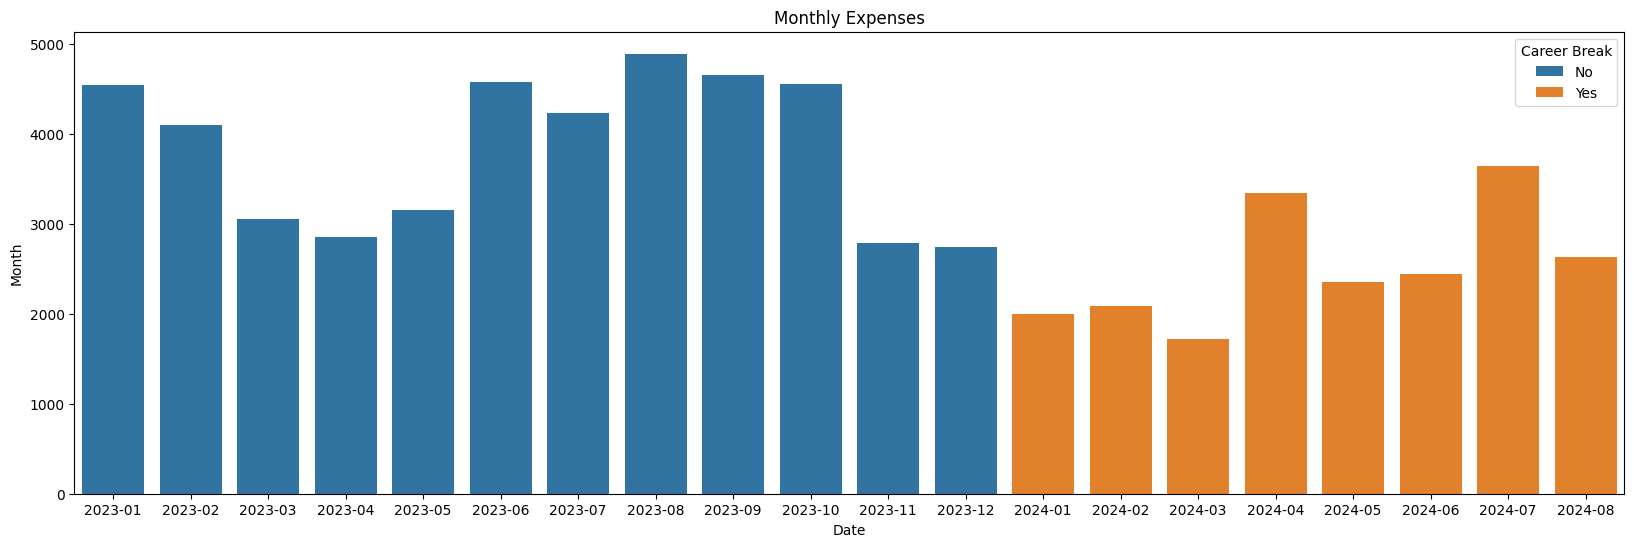

Average monthly expense while working: $3849.08
Average monthly expense while on a career break: $2527.61
Difference in average monthly expense: $1321.48 (34.33%)


In [160]:
# create dataframe containing only expense transaction records
expense_data = cleaned_finance_data[cleaned_finance_data.Type == "Expense"]

# group expenses by month
monthly_expense_data = expense_data.groupby(expense_data.Date.dt.to_period("M"))['Amount'].sum().to_frame()
monthly_expense_data['Career Break'] = np.where(monthly_expense_data.index.year < 2024, "No", "Yes")

# set the width and height of the figure
plt.figure(figsize=(20,6))

# add title
plt.title("Monthly Expenses")

# bar chart showing average arrival delay for Spirit Airlines flights by month
sns.barplot(x=monthly_expense_data.index, y=monthly_expense_data['Amount'], hue=monthly_expense_data['Career Break'])

# add label for vertical axis
plt.ylabel("Month")

# display the chart
plt.show()

# calculate difference between expenses while working and during career break
avg_monthly_expense_working = monthly_expense_data[monthly_expense_data['Career Break'] == "No"]["Amount"].mean()
avg_monthly_expense_career_break = monthly_expense_data[monthly_expense_data['Career Break'] == "Yes"]["Amount"].mean()

print("Average monthly expense while working: $" + "{:.2f}".format(avg_monthly_expense_working))
print("Average monthly expense while on a career break: $" + "{:.2f}".format(avg_monthly_expense_career_break))
print("Difference in average monthly expense: $" + "{:.2f} ({:.2f}".format(avg_monthly_expense_working-avg_monthly_expense_career_break, ((avg_monthly_expense_working-avg_monthly_expense_career_break)/avg_monthly_expense_working)*100) + "%)")

###Which expense categories (e.g. groceries, entertainment, travel) have seen the most significant change in spending?

In [174]:
# group expenses by month
monthly_expense_by_category_data = expense_data.groupby([expense_data.Date.dt.to_period("M"), expense_data.Category])['Amount'].sum().to_frame()

monthly_expense_by_category_data_pivot = pd.pivot_table(monthly_expense_by_category_data,
                                values='Amount',
                                index='Date',
                                columns='Category')

#monthly_expense_by_category_data_pivot

df = pd.DataFrame({"date_x":[2015]*5,
                   "Occurance_x":[2994, 2543, 2307, 1535, 1511],
                   "VTM_NM":["Not Specified", "Mesalazine", "Omeprazole",
                             "Esomeprazole", "Lansoprazole"],
                   "date_y":[2016]*5,
                   "Occurance_y":[3212, 2397, 2370, 1516, 1547]})
df

,date_x,Occurance_x,VTM_NM,date_y,Occurance_y
0,2015,2994,Not Specified,2016,3212
1,2015,2543,Mesalazine,2016,2397
2,2015,2307,Omeprazole,2016,2370
3,2015,1535,Esomeprazole,2016,1516
4,2015,1511,Lansoprazole,2016,1547


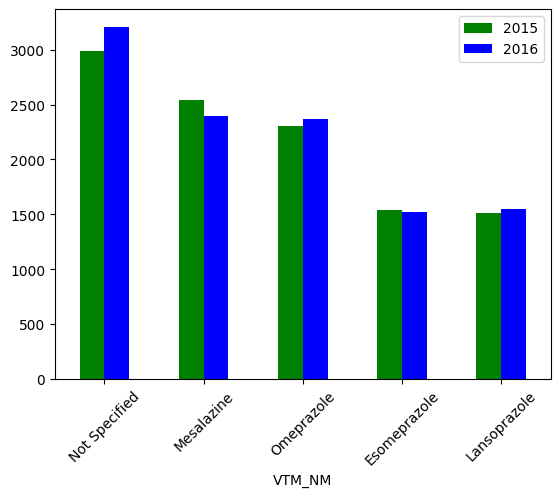

In [176]:
ax = df[["VTM_NM","Occurance_x", "Occurance_y"]].plot(x='VTM_NM',
                                                      kind='bar',
                                                      color=["g","b"],
                                                      rot=45)
ax.legend(["2015", "2016"])